In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# Prepare data

## Import

In [2]:
df = pd.read_csv("bankrupt_data.csv")

In [3]:
print(df.shape)
df.head()

(9792, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
0,0.159290,0.46240,0.07773,1.1683,-44.853,0.467020,0.189480,0.82895,1.1223,0.38330,...,0.108990,0.41557,0.89101,0.001422,7.7928,4.9914,119.810,3.0465,3.0560,0
1,-0.127430,0.46243,0.26917,1.7517,7.597,0.000925,-0.127430,1.16250,1.2944,0.53757,...,-0.089372,-0.23704,1.06250,0.150410,5.4327,3.4629,100.970,3.6150,3.4725,0
2,0.070488,0.23570,0.52781,3.2393,125.680,0.163670,0.086895,2.87180,1.0574,0.67689,...,0.054286,0.10413,0.94571,0.000000,7.1070,3.3808,76.076,4.7978,4.7818,0
3,0.136760,0.40538,0.31543,1.8705,19.115,0.504970,0.136760,1.45390,1.1144,0.58938,...,0.102630,0.23203,0.89737,0.073024,6.1384,4.2241,88.299,4.1337,4.6484,0
4,-0.110080,0.69793,0.18878,1.2713,-15.344,0.000000,-0.110080,0.43282,1.7350,0.30207,...,0.439880,-0.36440,0.57153,0.000000,18.8010,2.7925,146.390,2.4934,15.0360,0


## Explore

In [4]:
# inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9792 entries, 0 to 9791
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    9791 non-null   float64
 1   feat_2    9791 non-null   float64
 2   feat_3    9791 non-null   float64
 3   feat_4    9749 non-null   float64
 4   feat_5    9771 non-null   float64
 5   feat_6    9791 non-null   float64
 6   feat_7    9791 non-null   float64
 7   feat_8    9773 non-null   float64
 8   feat_9    9792 non-null   float64
 9   feat_10   9791 non-null   float64
 10  feat_11   9791 non-null   float64
 11  feat_12   9749 non-null   float64
 12  feat_13   9771 non-null   float64
 13  feat_14   9791 non-null   float64
 14  feat_15   9784 non-null   float64
 15  feat_16   9773 non-null   float64
 16  feat_17   9773 non-null   float64
 17  feat_18   9791 non-null   float64
 18  feat_19   9771 non-null   float64
 19  feat_20   9771 non-null   float64
 20  feat_21   9634 non-null   floa

Some features present NaN data, let us check how is that count compared to the lenght of the dataset

In [5]:
# Get the number of non-null values for each column
num_non_null = df.count()

# finding $ of missing values for each features
missing_values = ((1 - num_non_null/len(df))*100).sort_values()
missing_values.tail(10)

feat_41     1.909722
feat_24     2.154820
feat_53     2.359069
feat_54     2.359069
feat_64     2.359069
feat_28     2.359069
feat_45     6.260212
feat_60     6.270425
feat_27     6.546160
feat_37    45.363562
dtype: float64

In [6]:
num_non_null.idxmin()

'feat_37'

In [7]:
print(f"Column with minimum non-null values: {missing_values.tail(1).index.values[0]}; Number of NaN values on this feature:", df[num_non_null.idxmin()].isna().sum())
print(f"Percentage of the dataset lenght: {df[num_non_null.idxmin()].isna().sum()/len(df)*100:.2f}%")

Column with minimum non-null values: feat_37; Number of NaN values on this feature: 4442
Percentage of the dataset lenght: 45.36%


It is possible to see that feat_37, which stands for:

| Column Name | Description |
|-------------|-------------|
| feat_37     | (current assets - inventories) / long-term liabilities |


has a huge number of missing values(45.36%). Other missing values features do not go over 7% of missing values.  
We should work on some kind of Imputation method later on.

# Number of firms that are bankrupt

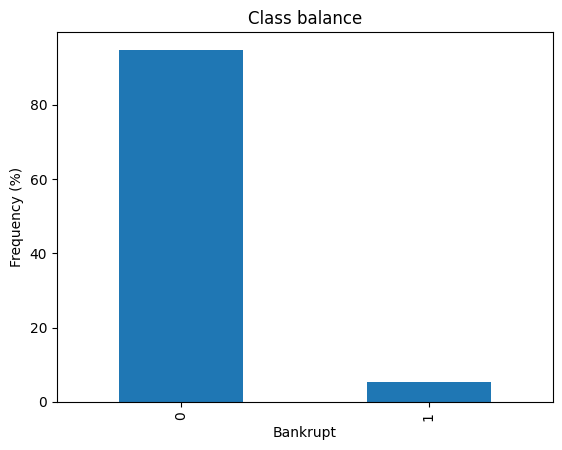

In [8]:
# plotting class balance
(df["bankrupt"].value_counts(normalize=True)*100).plot(
    kind="bar",
    xlabel="Bankrupt",
    ylabel="Frequency (%)",
    title="Class balance"
);

While it is great to realize most companies are not bankrupt, for our purposes (predict bankruptsy) it could be quite challenging to deal with such a huge imbalanced dataset.

# Outliers investigation

In [9]:
df.describe()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
count,9791.000000,9791.000000,9791.000000,9749.000000,9.771000e+03,9791.000000,9791.000000,9773.000000,9792.000000,9791.000000,...,9771.000000,9791.000000,9776.000000,9791.000000,9178.000000,9760.000000,9.771000e+03,9749.000000,9561.000000,9792.000000
mean,0.043019,0.596404,0.130959,8.136600,6.465164e+01,-0.059273,0.059446,19.884016,1.882296,0.389040,...,-0.992263,0.035022,1.133287,0.856053,118.156064,25.194430,2.015157e+03,8.660813,35.949619,0.052594
std,0.359321,4.587122,4.559074,290.647281,1.475939e+04,6.812754,0.533344,698.697015,17.674650,4.590299,...,77.007971,8.945365,8.038201,26.393305,3230.316692,1099.260821,1.171461e+05,60.838202,483.318623,0.223233
min,-12.458000,0.000000,-445.910000,-0.045319,-3.794600e+05,-486.820000,-12.458000,-1.848200,-0.032371,-445.910000,...,-7522.100000,-597.420000,-30.892000,-284.380000,0.000000,-12.656000,-1.496500e+04,-0.024390,-0.000015,0.000000
25%,0.001321,0.263145,0.020377,1.047000,-5.121700e+01,-0.000578,0.003004,0.428300,1.006675,0.294440,...,0.003121,0.008768,0.885722,0.000000,5.356325,4.267700,4.323400e+01,2.938800,2.012900,0.000000
50%,0.041364,0.467740,0.199290,1.591800,-5.557600e-02,0.000000,0.048820,1.088700,1.161300,0.510450,...,0.043679,0.098026,0.958305,0.002129,9.482000,6.283550,7.472900e+01,4.848900,4.041600,0.000000
75%,0.111130,0.689255,0.410670,2.880400,5.573200e+01,0.065322,0.126940,2.691000,1.970225,0.714290,...,0.117170,0.242680,0.996163,0.211790,19.506000,9.938200,1.233450e+02,8.363800,9.413500,0.000000
max,20.482000,446.910000,22.769000,27146.000000,1.034100e+06,322.200000,38.618000,53209.000000,1704.800000,12.602000,...,112.020000,226.760000,668.750000,1661.000000,251570.000000,108000.000000,1.077900e+07,5662.400000,21153.000000,1.000000


Let us find what features exhibits a great number of outliers.  
One way to do that is to find on which feature the mean is higher than X times the median.  
Let's start using X = 50, so, we should find the features where the mean > 50*median.

In [14]:
# finding features with outliers
df.drop("bankrupt", axis=1).describe().T.query('mean > 10 * `50%`')

,count,mean,std,min,25%,50%,75%,max
feat_5,9771.0,64.651636,14759.389477,-379460.0000,-51.217000,-0.055576,55.732000,1034100.0
feat_8,9773.0,19.884016,698.697015,-1.8482,0.428300,1.088700,2.691000,53209.0
feat_27,9151.0,1115.882762,31439.377937,-259010.0000,0.000000,1.005500,5.236100,2037300.0
feat_28,9561.0,6.725180,147.963574,-990.0200,0.035097,0.470770,1.570000,11864.0
feat_30,9771.0,5.353531,340.974268,-4940.0000,0.082730,0.226950,0.434085,29526.0
feat_37,5350.0,70.659877,621.311292,-3.7150,1.097050,3.110400,12.239750,24487.0
feat_40,9749.0,3.064235,87.916989,-8.8333,0.051234,0.182500,0.666480,8007.1
feat_41,9605.0,0.968902,41.191681,-1086.8000,0.025029,0.089499,0.215980,3443.4
feat_44,9771.0,672.989219,32811.281395,-115870.0000,36.519500,57.862000,85.109500,3020000.0
feat_45,9179.0,5.458024,186.414617,-2834.9000,0.010131,0.232560,0.816100,10337.0


In [11]:
# storing features with outliers
outliers_feat = df.drop("bankrupt", axis=1).describe().T.query('mean > 10 * `50%`').index.to_list()

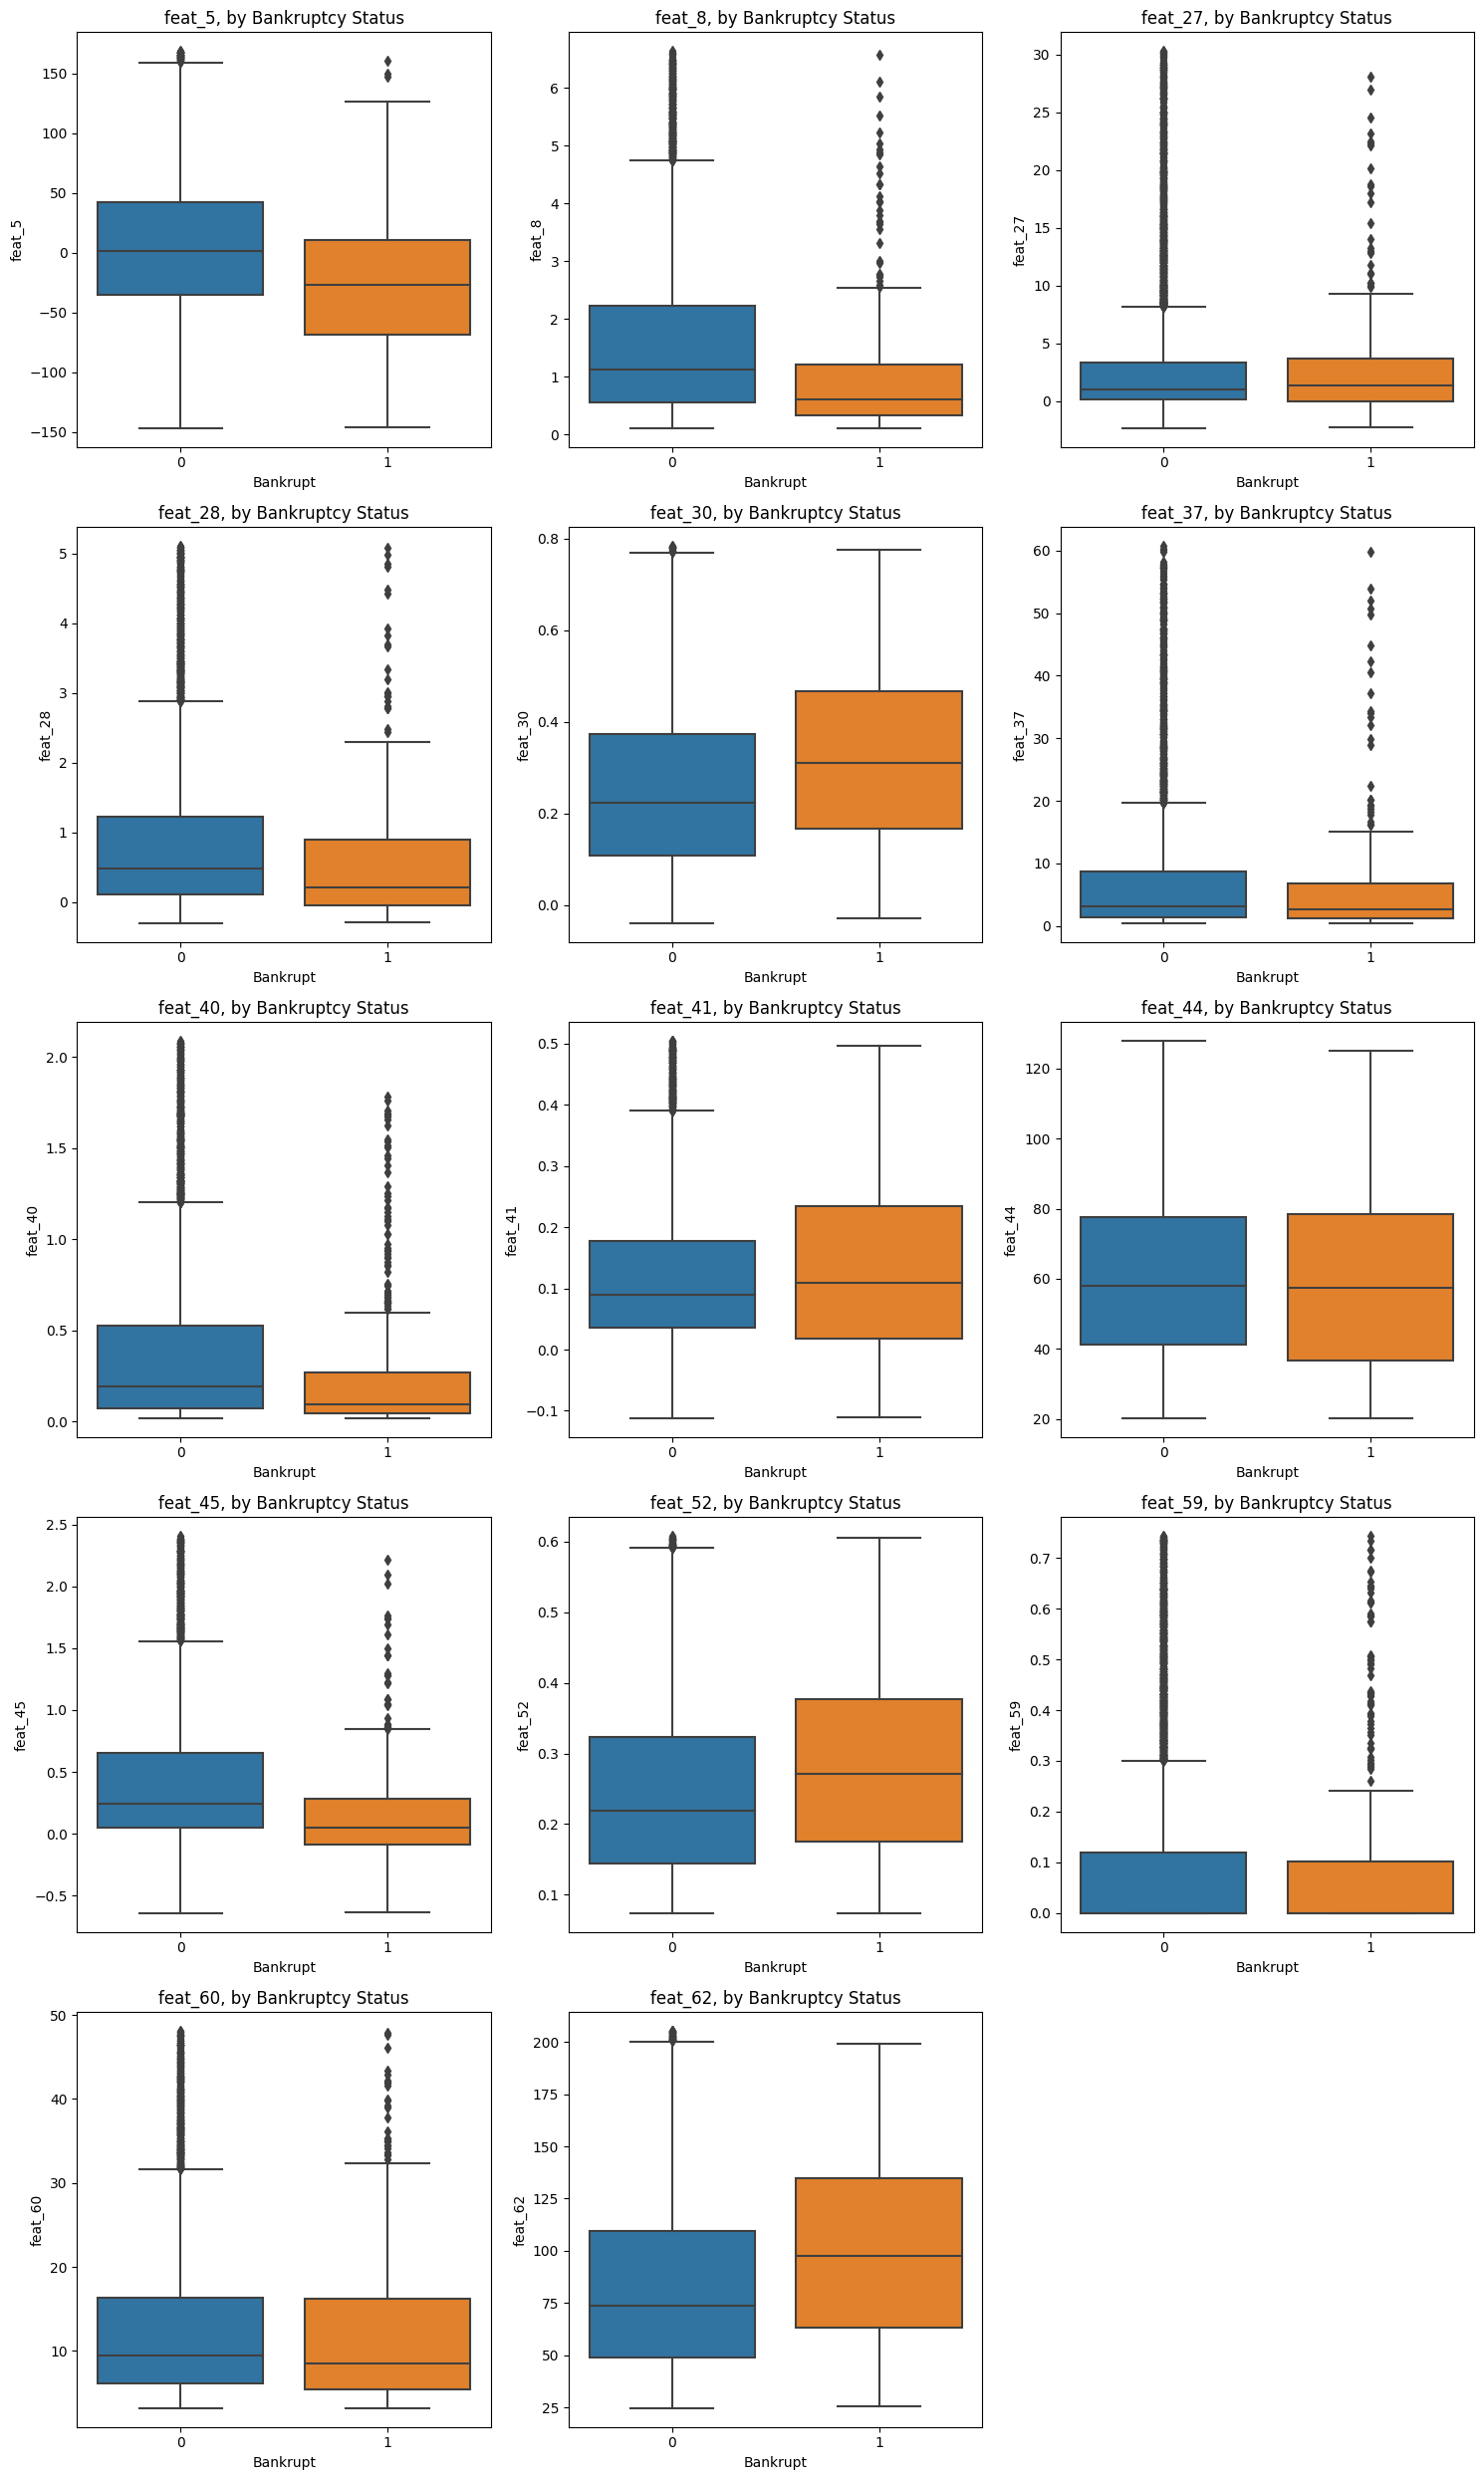

In [20]:
# boxplotting the features with outliers
# #df[outliers_feat + ["bankrupt"]]
# for feat in outliers_feat:
#     q1, q9 = df[feat].quantile([0.1, 0.9])
#     mask = df[feat].between(q1, q9)
#     plt.figure()
#     sns.boxplot(data=df[mask], y=feat, x="bankrupt")
#     plt.xlabel("Bankrupt")
#     plt.ylabel(feat)
#     plt.title(f"{feat}, by Bankruptcy Status");

num_rows = len(outliers_feat) // 3 + 1
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

for i, feat in enumerate(outliers_feat):
    q1, q9 = df[feat].quantile([0.1, 0.9])
    mask = df[feat].between(q1, q9)
    ax = axes[i // 3, i % 3]
    sns.boxplot(data=df[mask], y=feat, x="bankrupt", ax=ax)
    ax.set_xlabel("Bankrupt")
    ax.set_ylabel(feat)
    ax.set_title(f"{feat}, by Bankruptcy Status")

for j in range(len(outliers_feat) % 3, 3):
    axes[-1, j].axis("off")

plt.tight_layout()
plt.show()

Look's like even removing some outliers, i.e. using 10% to 90% range of data, some features does not presents notable difference on the distributions of bankrupt class, for example features:  
| Column Name | Description |
|-------------|-------------|
| **feat_27** | profit on operating activities / financial expenses                                                                 |  
| **feat_37** | (current assets - inventories) / long-term liabilities                                                              |  
| **feat_44** | (receivables * 365) / sales                                                                                         |  
| **feat_59** | long-term liabilities / equity                                                                                      |  
| **feat_60** | sales / inventory                                                                                                   | 

This will be important to keep in mind when it is time to decide which type of model we want to train.

## Multicolinearity

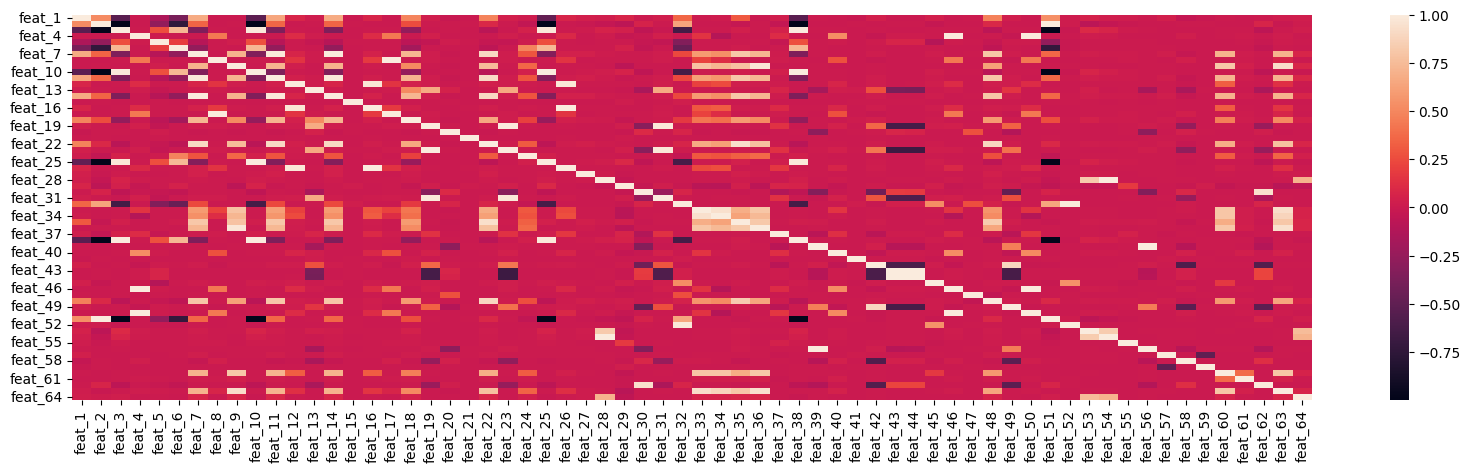

In [25]:
corr = df.drop(columns="bankrupt").corr()
plt.figure(figsize=(20,5))
sns.heatmap(corr);

# EDA takeaways:

Main characteristics of the dataset:
- Our data is imbalanced. This is something we need to address in our data preparation. 
- Many of our features have missing values that we'll need to impute. And since the features are highly skewed, the best imputation strategy is likely median, not mean. 
- It has autocorrelation issues, which means that we should steer clear of linear models, and try a tree-based model instead.

# Splitting data (train, test sets)

In [26]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9792, 64)
y shape: (9792,)


It's generally recommended to split the data into training and testing sets before handling missing values and imbalanced data because doing so helps to prevent data leakage.

Data leakage occurs when information from the testing set is inadvertently used to train the model. For example, if we impute missing values in the entire dataset before splitting it into training and testing sets, the imputation process will use information from the testing set to impute missing values in the training set, which can bias the model's performance on the testing set. Similarly, if we balance the classes by oversampling the minority class before splitting the data, the oversampling process can also leak information from the testing set to the training set, leading to overly optimistic performance estimates.

By splitting the data into training and testing sets first, we ensure that the training set is not influenced by information from the testing set, and thus provide a more realistic estimate of the model's performance on unseen data. Then, we can handle missing values and imbalance in the training set only, using only information from the training set, without any leakage from the testing set.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7833, 64)
y_train shape: (7833,)
X_test shape: (1959, 64)
y_test shape: (1959,)


# Resample

Let us now address the imbalance issue we found during our EDA. We will create two new training sets, one undersampling the majority class(not bankrupt), the other oversampling the minority class(bankrupt)

In [28]:
# under sample
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(824, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,-0.108110,0.63544,0.26025,1.4971,-28.833,0.004055,-0.108110,0.57372,3.06580,0.36456,...,647.46,-0.030213,-0.29656,1.03460,0.21445,6.9003,11.2580,62.3250,5.8564,14.1770
1,0.072075,0.13204,0.57123,43.4340,16690.000,0.000000,0.072075,6.57320,4.54050,0.86796,...,6018.00,0.011994,0.08304,0.98942,0.00000,475.6100,46.8050,1.0821,337.2900,10.9330
2,-0.103510,0.46558,0.22585,1.4851,-28.402,0.000000,-0.103510,1.14780,1.67980,0.53441,...,694.06,0.186460,-0.19369,0.82996,0.00000,5.8425,4.8286,101.1600,3.6080,5.4440
3,-0.013073,0.49739,0.21777,1.4494,-50.806,-0.492130,-0.013073,1.01050,0.85381,0.50261,...,1501.70,-0.230440,-0.02601,1.01200,0.00000,2.4641,3.0051,207.1700,1.7619,2.8688
4,0.091075,0.35537,0.16173,1.6784,27.868,0.000000,0.091075,1.81400,1.06450,0.64463,...,27704.00,0.316450,0.14128,0.69498,0.15279,14.4160,4.8966,81.7450,4.4651,1.7746


In [30]:
# double checking target class balance
y_train_under.value_counts(normalize=True)

bankrupt
0    0.5
1    0.5
Name: proportion, dtype: float64

In [31]:
# over sample
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(14842, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.069548,0.69574,0.055553,1.0897,-27.2160,-0.264400,0.069113,0.36634,1.0355,0.25488,...,580.85,0.034314,0.272870,0.96569,0.30020,10.9890,6.4865,85.355,4.2762,8.1421
1,-0.084151,0.62034,0.114540,1.2505,-5.9921,0.000000,-0.084151,0.61202,1.6597,0.37966,...,557.14,-0.121260,-0.221650,1.04600,0.00000,11.5100,7.3495,100.560,3.6295,3.8759
2,0.081425,0.10163,0.424230,5.1741,124.5500,0.297150,0.101460,8.52550,1.1220,0.86647,...,18200.00,0.108710,0.093974,0.89129,0.00000,5.5087,3.9838,41.429,8.8102,1.8885
3,0.011690,0.80729,-0.216890,0.6474,-124.9500,-0.037361,0.011781,0.23871,1.0410,0.19271,...,-3420.70,0.039353,0.060664,0.96065,0.99729,17.1860,2.5425,259.880,1.4045,1.4356
4,0.000917,0.33013,0.591420,2.8261,-30.7370,0.000000,0.000917,2.02910,1.4833,0.66987,...,3355.10,0.270390,0.001369,0.73336,0.00000,2.2321,6.9965,79.698,4.5798,17.5120


In [32]:
# double checking target class balance
y_train_over.value_counts(normalize=True)

bankrupt
0    0.5
1    0.5
Name: proportion, dtype: float64

# Build model

## Baseline

In [33]:
# Let us first define our baseline as the Accuracy score
# considering that we classify every firm as not bankrupt
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9474


## Iterating trough regular train set, under-sample train set and over-sample train set

Considering a SimpleImputer approach using median, and a DecisionTreeClassifier model.

In [34]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

# Evaluate

In [36]:
# getting accuracy score for train and test set for each model
for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train, y_train)
    acc_test = m.score(X_test, y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9239
Training Accuracy: 0.7153
Test Accuracy: 0.6937
Training Accuracy: 1.0
Test Accuracy: 0.9316


"Good" accuracy scores don't tell us much about the model's performance when dealing with imbalanced data. So instead of looking at what the model got right or wrong, let's see how its predictions differ for the two classes in the dataset.

Let us plot a Confusion Matrix for the "best" accuracy model, a.k.a. model_over (over sampled minority class)

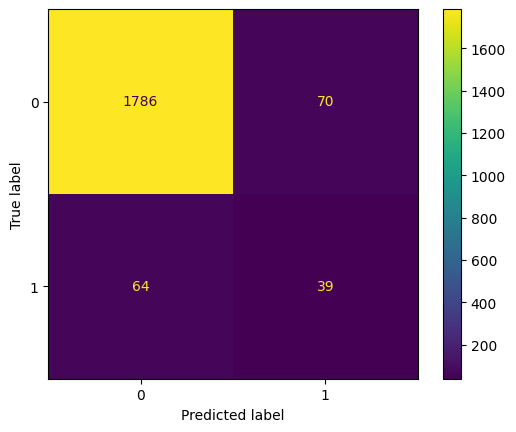

In [38]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_over, X_test, y_test);

Recall and precision are two commonly used metrics for evaluating the performance of a binary classification model (imbalanced classes).  
Recall measures the proportion of actual positive cases that are correctly identified as positive by the model. It is calculated as:  
Recall = True Positives / (True Positives + False Negatives)  
Precision measures the proportion of positive predictions made by the model that are actually positive. It is calculated as:  
Precision = True Positives / (True Positives + False Positives)

In [46]:
print("Recall    = ", f"{(39/(39+64)*100):.2f}%")
print("Precision = ", f"{(39/(39+70)*100):.2f}%")

Recall    =  37.86%
Precision =  35.78%


That shows us that we shall revaluate our model selection on further steps.

# Communicating our results

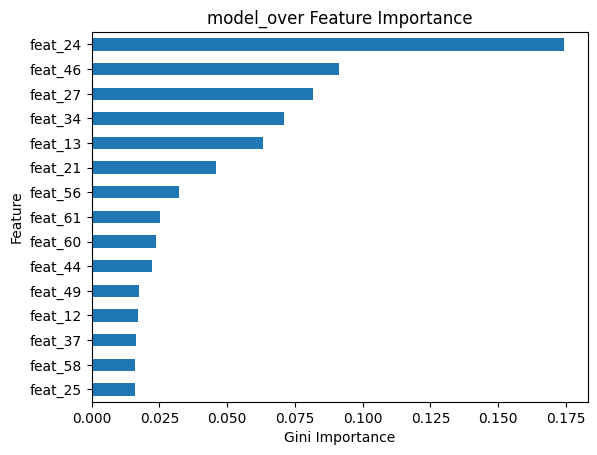

In [47]:
# Get importances
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index=X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

In [48]:
# sharing our trained model
with open("dtree_model", "wb") as f:
    pickle.dump(model_over, f)

In [51]:
# loading our model to check if it was correctly saved
with open("dtree_model", "rb") as f:
    loaded_model = pickle.load(f)

print(loaded_model)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])


In [54]:
# testing loaded model
loaded_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [56]:
# double checking number of predicted bankrupt companies (should be 109, 39 TP + 70 FP)
loaded_model.predict(X_test).sum()

109